In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mesa_reader

It should be noted that `core_mass` is calculated as the mass of the outermost `burning` zone AKA the first zone fully within the core.

Core compositions calculations are a bit more complicated. We need to sum over the core zones and produce a mass fraction for each element.

It goes something like this:

$$\frac{1}{m_*}\sum_{i=n_i}^{n_f} (m_i \times x_i)$$

Where:

$
\begin{align}
m_* &= \text{The mass of the star in kg} \\
n_i &= \text{The first zone in the core} \\
n_f &= \text{The last zone in the core} \\
m_i &= \text{The mass of the zone in kg} \\
x_i &= \text{The mass fraction of the element in the zone}
\end{align}
$

This is repeated for each element.

In [2]:
SOLAR_MASS = 1.989 * 10 ** 30  # kg
SOLAR_RADIUS = 696340 * 1000  # m

elements = {
    'h1': 'H',
    'he3': 'He3',
    'he4': 'He',
    'c12': 'C',
    'n14': 'N',
    'o16': 'O',
    'ne20': 'Ne',
    'mg24': 'Mg',
}

## Data object for stellar profiles, including detailed temperature-density profiles, core radius/mass, reaction rates, composition, etc.
class Zone:
    def __init__(self, zone_number, thickness, top, temperature, mass, next_zone_mass, reaction_rates, composition: dict[str, float]):
        """
        :param zone_number: Number of the zone
        :param thickness: Thickness of the zone in log10 cm
        :param top: Radius at outer boundary of the zone in log10 Rsun
        :param temperature: Temperature at the center of the zone in log10 K
        :param mass: Mass from the outer edge of the zone to the center in log10 Msun
        :param next_zone_mass: Mass from the outer edge of the next zone inwards to the center of the star in log10 Msun
        :param reaction_rates: Raw reactions/second of he3+he3->h1+h1+he4 in the zone
        :param composition: Mass fractions of the zone
        """

        self.zone_number = zone_number
        self.thickness = (10 ** thickness) / 100 # log10 cm => m
        self.top = (10 ** top) * SOLAR_RADIUS # log10 Rsun => m
        bottom = self.top - self.thickness # m
        self.temperature = 10 ** temperature # log10 K => K
        self.mass = (mass - next_zone_mass) * SOLAR_MASS # Msun => kg
        self.mass_coordinate = mass * SOLAR_MASS # Msun => kg
        self.reaction_rates = reaction_rates
        self.composition = composition

        self.volume = 4/3 * np.pi * (np.power(self.top, 3) - np.power(bottom, 3)) # Volume of the shell, m^3
        self.density = self.mass / self.volume # kg/m^3

    def to_record(self):
        record = {
            'zone_number': self.zone_number,
            'thickness': self.thickness,
            'top': self.top,
            'temperature': self.temperature,
            'mass': self.mass,
            'reaction_rates': self.reaction_rates,
            'volume': self.volume,
            'density': self.density,
        }

        for element in self.composition:
            record[element] = self.composition[element]

        return record

class StellarProfile:
    def __init__(self, source_id, batch_idx, iteration_idx, mass, core_radius, radius, original_radius, age, original_age, zones: list[Zone]):
        """
        :param source_id: Source ID of the star
        :param batch_idx: Batch index of the simulation
        :param iteration_idx: Iteration index of the simulation
        :param mass: Mass of the star in Msun
        :param core_radius: Radius of the core in log10 Rsun
        :param core_radius: Size of core relative to the simulation radius (which is in log10 Rsun)
        :param radius: Radius of the simulated star in log10 Rsun
        :param original_radius: Original radius of the star for error calculations Rsun
        :param age: Age of the simulated star in years
        :param original_age: Original age of the star for error calculations
        :param zones: All profile zones, will be filtered to only include the core
        """

        self.source_id = source_id
        self.batch_idx = batch_idx
        self.iteration_idx = iteration_idx
        self.mass = mass * SOLAR_MASS # Msun => kg
        self.radius = (10 ** radius) * SOLAR_RADIUS # log10 Rsun => m
        self.normalized_core_radius = core_radius
        self.core_radius = core_radius * self.radius # Normalized (Rsun) => m
        self.original_radius = original_radius * SOLAR_RADIUS # Rsun => m
        self.age = age
        self.original_age = original_age

        burning_zones = []
        records = []

        for zone in zones:
            if zone.top < self.core_radius:
                burning_zones.append(zone)
                records.append(zone.to_record())

        ### Sort by zone numbers
        burning_zones.sort(key=lambda x: x.zone_number)

        self.burning_zones = pd.DataFrame(records)

        ### Calculate core mass
        self.core_mass = self.burning_zones['mass'].sum()

        self.core_volume = 4/3 * np.pi * np.power(self.core_radius, 3) # m^3
        self.core_density = (self.burning_zones['density'] * self.burning_zones['mass']).sum() / self.core_mass
        self.core_temperature = (self.burning_zones['temperature'] * self.burning_zones['mass']).sum() / self.core_mass

        self.reaction_rates = self.burning_zones['reaction_rates'].sum()
        self.reaction_rates_per_unit_volume = self.reaction_rates / self.core_volume # reactions/second/m^3

        # Core composition
        self.composition = {}

        for element in elements.values():
            self.composition[element] = 0
            mass_sum = (self.burning_zones[element] * self.burning_zones['mass']).sum()
            self.composition[element] = mass_sum / self.core_mass


    @staticmethod
    def error(original, calculated):
        return (calculated - original) / original

    def to_record(self):
        original_core_radius = self.normalized_core_radius * self.original_radius
        original_volume = 4/3 * np.pi * np.power(original_core_radius, 3)
        original_reaction_rates_per_unit_volume = self.reaction_rates / original_volume

        record = {
            'source_id': self.source_id,
            'batch_idx': self.batch_idx,
            'iteration_idx': self.iteration_idx,
            'mass': self.mass,
            'core_radius': self.core_radius,
            'core_radius_error': StellarProfile.error(original_core_radius, self.core_radius),
            'original_core_radius': original_core_radius,
            'radius': self.radius,
            'radius_error': StellarProfile.error(self.original_radius, self.radius),
            'original_radius': self.original_radius,
            'age': self.age,
            'original_age': self.original_age,
            'age_error': StellarProfile.error(self.original_age, self.age),
            'core_mass': self.core_mass,
            'core_volume': self.core_volume,
            'core_volume_error': StellarProfile.error(original_volume, self.core_volume),
            'original_core_volume': original_volume,
            'core_density': self.core_density,
            'core_temperature': self.core_temperature,
            'reaction_rates_per_unit_volume': self.reaction_rates_per_unit_volume,
            'reaction_rates_error': StellarProfile.error(original_reaction_rates_per_unit_volume, self.reaction_rates_per_unit_volume),
            'original_reaction_rates_per_unit_volume': original_reaction_rates_per_unit_volume,
            'burning_zones': self.burning_zones.to_dict(orient='records'),
        }

        for element in self.composition:
            record[element] = self.composition[element]

        return record

    def temperature_density_profile(self):
        densities = self.burning_zones['density']
        temperatures = self.burning_zones['temperature']
        radii = self.burning_zones['top']

        return [radii, temperatures, densities]

    def temperature_density_profile_2d(self):
        densities = self.burning_zones['density']
        temperatures = self.burning_zones['temperature']

        return [densities, temperatures]

    def temperature_profile(self):
        temperatures = self.burning_zones['temperature']
        radii = self.burning_zones['top']

        return [radii, temperatures]

    def density_profile(self):
        densities = self.burning_zones['density']
        radii = self.burning_zones['top']

        return [radii, densities]

## Parsing simulation history files
In the `simulate/LOGS` directory, all of the simulation output files are stored (one directory per thread).

The first five lines are not needed, so we will skip them.
The sixth line is the header, which contains the column names.
The last line is the latest output, which contains the final values.

In [3]:
output_headers = ['source_id', 'batch_idx', 'iteration_idx', 'radius', 'e_radius', 'mass', 'e_mass', 'age', 'y', 'z', 'log_cntr_P', 'log_cntr_Rho', 'log_cntr_T', 'core_radius', 'core_mass',
           'H', 'He3', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'pp_rate']
output = []

profiles = {} # source_id -> StellarProfile

records = []

for directory in os.scandir('simulate/LOGS'):
    dir_name = directory.name
    thread_num = int(dir_name.split('/')[-1])
    _data = pd.read_csv(f'simulate/run/{thread_num}/data.csv', dtype={'source_id': str})  # Source data
    path = Path(f'simulate/LOGS/{dir_name}')

    for dir in path.iterdir():
        idx = int(dir.name)

        data = mesa_reader.MesaLogDir(f'simulate/LOGS/{dir_name}/{idx}', memoize_profiles=False)

        history_data: mesa_reader.MesaData = data.history_data
        last_profile: mesa_reader.MesaData = data.profile_data()

        row_data = []
        headers = []

        for i in history_data.bulk_data[-1]:
            row_data.append(i)

        for i in history_data.bulk_names:
            headers.append(i)

        df = pd.DataFrame([row_data], columns=headers)
        row = _data.iloc[idx]
        core_radius = 0

        radius = df['log_R'].iloc[-1]
        original_radius = row['radius']

        age = df['star_age'].iloc[-1]
        original_age = row['age']

        for i in range(1, 10):
            burn_type = int(df[f'burn_relr_type_{i}'].iloc[-1])
            val = float(df[f'burn_relr_top_{i}'].iloc[-1])
            if burn_type != -9999 and val != 1 and val > 0:
                core_radius = val
            elif burn_type == -9999 and val == 1:
                break

        profile_data_raw = pd.DataFrame(last_profile.bulk_data, columns=last_profile.bulk_names)
        profile_data_raw['next_mass'] = profile_data_raw['mass'].shift(-1)
        profile_data_raw['next_mass'].fillna(0, inplace=True)

        zones = []

        log_dr_array = profile_data_raw['log_dr'].values
        logR_array = profile_data_raw['logR'].values
        logT_array = profile_data_raw['logT'].values
        mass_array = profile_data_raw['mass'].values
        next_mass_array = profile_data_raw['next_mass'].values
        raw_rate_array = profile_data_raw['raw_rate_r_he3_he3_to_h1_h1_he4'].values

        element_names = list(elements.keys())
        element_columns = {el: profile_data_raw[el].values for el in element_names}
        element_mapped_names = [elements[el] for el in element_names]

        for i in range(len(profile_data_raw)):
            composition = {element_mapped_names[j]: element_columns[element_names[j]][i] for j in range(len(element_names))}

            # Append a new Zone
            zones.append(Zone(
                zone_number=profile_data_raw.index[i],
                thickness=log_dr_array[i],
                top=logR_array[i],
                temperature=logT_array[i],
                mass=mass_array[i],
                next_zone_mass=next_mass_array[i],
                reaction_rates=raw_rate_array[i],
                composition=composition,
            ))

        profile = StellarProfile(row['source_id'], int(dir_name), idx, row['mass'], core_radius, radius, original_radius, age, original_age, zones)
        records.append(profile.to_record())
        profiles[row['source_id']] = profile

        print(f'Finished {dir_name}/{idx} ({len(records)} processed)')

df = pd.DataFrame(records)
df.set_index('source_id', inplace=True)

Finished 0/0 (1 processed)
Finished 0/1 (2 processed)
Finished 0/10 (3 processed)
Finished 0/100 (4 processed)
Finished 0/101 (5 processed)
Finished 0/102 (6 processed)
Finished 0/103 (7 processed)
Finished 0/104 (8 processed)
Finished 0/105 (9 processed)
Finished 0/106 (10 processed)
Finished 0/107 (11 processed)
Finished 0/108 (12 processed)
Finished 0/109 (13 processed)
Finished 0/11 (14 processed)
Finished 0/110 (15 processed)
Finished 0/111 (16 processed)
Finished 0/112 (17 processed)
Finished 0/113 (18 processed)
Finished 0/114 (19 processed)
Finished 0/115 (20 processed)
Finished 0/116 (21 processed)
Finished 0/117 (22 processed)
Finished 0/118 (23 processed)
Finished 0/119 (24 processed)
Finished 0/12 (25 processed)
Finished 0/120 (26 processed)
Finished 0/121 (27 processed)
Finished 0/122 (28 processed)
Finished 0/123 (29 processed)
Finished 0/124 (30 processed)
Finished 0/125 (31 processed)
Finished 0/126 (32 processed)
Finished 0/127 (33 processed)
Finished 0/128 (34 process

In [4]:
df.to_json('./stellar_profiles.json', orient='records')
df

batch_idx  iteration_idx          mass   core_radius  \
source_id                                                                   
2268469823008193152          0              0  1.637225e+30  1.179559e+08   
2264752202396093440          0              1  1.621123e+30  1.188506e+08   
2268087910219685504          0             10  1.445228e+30  1.009805e+08   
1244590404650553600          0            100  1.895295e+30  1.382939e+08   
6242646355272876928          0            101  1.823523e+30  1.321363e+08   
...                        ...            ...           ...           ...   
1406352685632976768          3             95  2.026285e+30  1.473643e+08   
1406689411068933504          3             96  1.718444e+30  1.237558e+08   
1403476981690082304          3             97  1.907885e+30  1.361816e+08   
1392090267474126848          3             98  2.388658e+30  1.649205e+08   
1392097311220494848          3             99  2.030161e+30  1.441265e+08   

                     core_radius_error  original_core_radius        radius  \
source_id                                                                    
2268469823008193152          -0.030944          1.217226e+08  5.890937e+08   
2264752202396093440           0.021081          1.163968e+08  5.827517e+08   
2268087910219685504          -0.006525          1.016437e+08  4.962256e+08   
1244590404650553600           0.063856          1.299931e+08  7.505098e+08   
6242646355272876928          -0.045321          1.384092e+08  6.934996e+08   
...                                ...                   ...           ...   
1406352685632976768           0.050809          1.402388e+08  6.902319e+08   
1406689411068933504          -0.044443          1.295117e+08  6.013815e+08   
1403476981690082304           0.031577          1.320130e+08  8.186071e+08   
1392090267474126848           0.016488          1.622454e+08  1.127347e+09   
1392097311220494848          -0.033735          1.491583e+08  7.776789e+08   

                     radius_error  original_radius           age  ...  \
source_id                                                         ...   
2268469823008193152     -0.030944     6.079048e+08  1.299812e+10  ...   
2264752202396093440      0.021081     5.707203e+08  1.114927e+10  ...   
2268087910219685504     -0.006525     4.994847e+08  1.233394e+10  ...   
1244590404650553600      0.063856     7.054621e+08  7.745124e+09  ...   
6242646355272876928     -0.045321     7.264219e+08  9.557687e+09  ...   
...                           ...              ...           ...  ...   
1406352685632976768      0.050809     6.568575e+08  1.976276e+09  ...   
1406689411068933504     -0.044443     6.293521e+08  9.341452e+09  ...   
1403476981690082304      0.031577     7.935491e+08  1.010472e+10  ...   
1392090267474126848      0.016488     1.109061e+09  4.489689e+09  ...   
1392097311220494848     -0.033735     8.048298e+08  7.039093e+09  ...   

                     original_reaction_rates_per_unit_volume  \
source_id                                                      
2268469823008193152                             3.908873e+12   
2264752202396093440                             5.005955e+12   
2268087910219685504                             3.163105e+12   
1244590404650553600                             6.358758e+12   
6242646355272876928                             4.222233e+12   
...                                                      ...   
1406352685632976768                             6.447732e+12   
1406689411068933504                             3.827388e+12   
1403476981690082304                             4.947447e+12   
1392090267474126848                             4.928707e+12   
1392097311220494848                             4.043312e+12   

                                                         burning_zones  \
source_id                                                                
2268469823008193152  [{'zone_number': 697, 'thickness': 741941.5974...   

In [5]:
df_original = df

In [83]:
df = df_original[df_original['age_error'] >= 0]
df

batch_idx  iteration_idx          mass   core_radius  \
source_id                                                                   
2268469823008193152          0              0  1.637225e+30  1.179559e+08   
2264752202396093440          0              1  1.621123e+30  1.188506e+08   
2268087910219685504          0             10  1.445228e+30  1.009805e+08   
1244590404650553600          0            100  1.895295e+30  1.382939e+08   
6242646355272876928          0            101  1.823523e+30  1.321363e+08   
...                        ...            ...           ...           ...   
1406352685632976768          3             95  2.026285e+30  1.473643e+08   
1406689411068933504          3             96  1.718444e+30  1.237558e+08   
1403476981690082304          3             97  1.907885e+30  1.361816e+08   
1392090267474126848          3             98  2.388658e+30  1.649205e+08   
1392097311220494848          3             99  2.030161e+30  1.441265e+08   

                     core_radius_error  original_core_radius        radius  \
source_id                                                                    
2268469823008193152          -0.030944          1.217226e+08  5.890937e+08   
2264752202396093440           0.021081          1.163968e+08  5.827517e+08   
2268087910219685504          -0.006525          1.016437e+08  4.962256e+08   
1244590404650553600           0.063856          1.299931e+08  7.505098e+08   
6242646355272876928          -0.045321          1.384092e+08  6.934996e+08   
...                                ...                   ...           ...   
1406352685632976768           0.050809          1.402388e+08  6.902319e+08   
1406689411068933504          -0.044443          1.295117e+08  6.013815e+08   
1403476981690082304           0.031577          1.320130e+08  8.186071e+08   
1392090267474126848           0.016488          1.622454e+08  1.127347e+09   
1392097311220494848          -0.033735          1.491583e+08  7.776789e+08   

                     radius_error  original_radius           age  ...  \
source_id                                                         ...   
2268469823008193152     -0.030944     6.079048e+08  1.299812e+10  ...   
2264752202396093440      0.021081     5.707203e+08  1.114927e+10  ...   
2268087910219685504     -0.006525     4.994847e+08  1.233394e+10  ...   
1244590404650553600      0.063856     7.054621e+08  7.745124e+09  ...   
6242646355272876928     -0.045321     7.264219e+08  9.557687e+09  ...   
...                           ...              ...           ...  ...   
1406352685632976768      0.050809     6.568575e+08  1.976276e+09  ...   
1406689411068933504     -0.044443     6.293521e+08  9.341452e+09  ...   
1403476981690082304      0.031577     7.935491e+08  1.010472e+10  ...   
1392090267474126848      0.016488     1.109061e+09  4.489689e+09  ...   
1392097311220494848     -0.033735     8.048298e+08  7.039093e+09  ...   

                     original_reaction_rates_per_unit_volume  \
source_id                                                      
2268469823008193152                             3.908873e+12   
2264752202396093440                             5.005955e+12   
2268087910219685504                             3.163105e+12   
1244590404650553600                             6.358758e+12   
6242646355272876928                             4.222233e+12   
...                                                      ...   
1406352685632976768                             6.447732e+12   
1406689411068933504                             3.827388e+12   
1403476981690082304                             4.947447e+12   
1392090267474126848                             4.928707e+12   
1392097311220494848                             4.043312e+12   

                                                         burning_zones  \
source_id                                                                
2268469823008193152  [{'zone_number': 697, 'thickness': 741941.5974...   

In [131]:
_df = df.copy()

_df = _df[_df['reaction_rates_error'] <= 0.05]
_df = _df[_df['reaction_rates_error'] >= -0.05]

core_density_iqr = _df['core_density'].quantile(0.75) - _df['core_density'].quantile(0.25)
temperature_iqr = _df['core_temperature'].quantile(0.75) - _df['core_temperature'].quantile(0.25)
reaction_rates_iqr = _df['reaction_rates_per_unit_volume'].quantile(0.75) - _df['reaction_rates_per_unit_volume'].quantile(0.25)

_df = _df[_df['core_density'] >= df['core_density'].quantile(0.25) - 1.5 * core_density_iqr]
_df = _df[_df['core_temperature'] >= df['core_temperature'].quantile(0.25) - 1.5 * temperature_iqr]
_df = _df[_df['reaction_rates_per_unit_volume'] >= df['reaction_rates_per_unit_volume'].quantile(0.25) - 1.5 * reaction_rates_iqr]
_df = _df[_df['core_density'] <= df['core_density'].quantile(0.75) + 1.5 * core_density_iqr]
_df = _df[_df['core_temperature'] <= df['core_temperature'].quantile(0.75) + 1.5 * temperature_iqr]
_df = _df[_df['reaction_rates_per_unit_volume'] <= df['reaction_rates_per_unit_volume'].quantile(0.75) + 1.5 * reaction_rates_iqr]

_df

batch_idx  iteration_idx          mass   core_radius  \
source_id                                                                   
2268101727131230464          0             11  1.723568e+30  1.250814e+08   
3895763112473649152          0            110  1.765144e+30  1.277347e+08   
3662578102339135872          0            120  1.826111e+30  1.326846e+08   
4015518311198187392          0            124  1.549273e+30  1.132899e+08   
4015792467550694528          0            125  1.678619e+30  1.224585e+08   
...                        ...            ...           ...           ...   
1592334733874661248          3             82  1.666220e+30  1.206921e+08   
3012028167748284800          3             86  1.482302e+30  1.074405e+08   
1352382401469775744          3             87  1.673692e+30  1.230972e+08   
1356125242130116864          3             91  1.654827e+30  1.210012e+08   
1392090267474126848          3             98  2.388658e+30  1.649205e+08   

                     core_radius_error  original_core_radius        radius  \
source_id                                                                    
2268101727131230464          -0.011037          1.264774e+08  5.690351e+08   
3895763112473649152           0.015933          1.257313e+08  7.205226e+08   
3662578102339135872           0.012678          1.310235e+08  6.846479e+08   
4015518311198187392           0.011765          1.119726e+08  5.117721e+08   
4015792467550694528           0.009647          1.212884e+08  6.013956e+08   
...                                ...                   ...           ...   
1592334733874661248           0.009652          1.195383e+08  5.333423e+08   
3012028167748284800          -0.011068          1.086429e+08  5.028397e+08   
1352382401469775744           0.009467          1.219428e+08  6.404413e+08   
1356125242130116864           0.014019          1.193283e+08  5.664350e+08   
1392090267474126848           0.016488          1.622454e+08  1.127347e+09   

                     radius_error  original_radius           age  ...  \
source_id                                                         ...   
2268101727131230464     -0.011037     5.753857e+08  4.301907e+09  ...   
3895763112473649152      0.015933     7.092223e+08  1.264748e+10  ...   
3662578102339135872      0.012678     6.760765e+08  8.774010e+09  ...   
4015518311198187392      0.011765     5.058214e+08  5.205248e+09  ...   
4015792467550694528      0.009647     5.956492e+08  1.013841e+10  ...   
...                           ...              ...           ...  ...   
1592334733874661248      0.009652     5.282435e+08  2.049094e+09  ...   
3012028167748284800     -0.011068     5.084675e+08  8.986472e+09  ...   
1352382401469775744      0.009467     6.344354e+08  1.220903e+10  ...   
1356125242130116864      0.014019     5.586039e+08  7.294005e+09  ...   
1392090267474126848      0.016488     1.109061e+09  4.489689e+09  ...   

                     original_reaction_rates_per_unit_volume  \
source_id                                                      
2268101727131230464                             4.120732e+12   
3895763112473649152                             4.873259e+12   
3662578102339135872                             5.180590e+12   
4015518311198187392                             4.076657e+12   
4015792467550694528                             4.825255e+12   
...                                                      ...   
1592334733874661248                             3.950863e+12   
3012028167748284800                             3.677288e+12   
1352382401469775744                             5.149308e+12   
1356125242130116864                             4.687335e+12   
1392090267474126848                             4.928707e+12   

                                                         burning_zones  \
source_id                                                                
2268101727131230464  [{'zone_number': 692, 'thickness': 700627.3420...   

In [19]:
# Check normality
from scipy.stats import shapiro, kstest

_density_shapiro = shapiro(_df['core_density'])
_temperature_shapiro = shapiro(_df['core_temperature'])
_reaction_rates_shapiro = shapiro(_df['reaction_rates_per_unit_volume'])

print(f'Density: p-value = {_density_shapiro.pvalue:.5f}, statistic = {_density_shapiro.statistic:.5f}')
print(f'Temperature: p-value = {_temperature_shapiro.pvalue:.5f}, statistic = {_temperature_shapiro.statistic:.5f}')
print(f'Reaction Rates: p-value = {_reaction_rates_shapiro.pvalue:.5f}, statistic = {_reaction_rates_shapiro.statistic:.5f}')

Density: p-value = 0.01688, statistic = 0.98951
Temperature: p-value = 0.00256, statistic = 0.98602
Reaction Rates: p-value = 0.00010, statistic = 0.97935


Loading profile 2413808625790287872


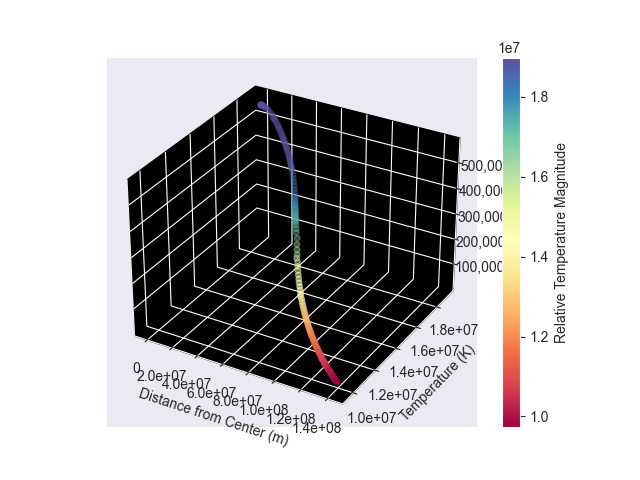

In [20]:
%matplotlib widget
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

random_profile = df.sample(1).index[0]
_id = random_profile
print(f'Loading profile {_id}')
profile = profiles[_id].temperature_density_profile()
temps = profile[1]

norm = Normalize(vmin=temps.min(), vmax=temps.max())

scatter = ax.scatter(profile[0], profile[1], profile[2], s=16, c=temps, cmap='Spectral', norm=norm)
plt.colorbar(scatter, label='Relative Temperature Magnitude')

def inline_scientific_formatter(value, _):
    if value == 0:
        return "0"
    return f"{value:.1e}"  # Format as 1.0e+7, 1.0e+6, etc.

def comma_formatter(x, pos):
    return f'{x:,.0f}'

formatter = FuncFormatter(inline_scientific_formatter)

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.zaxis.set_major_formatter(FuncFormatter(comma_formatter))

ax.set_xlabel('Distance from Center (m)')
ax.set_ylabel('Temperature (K)')
ax.set_zlabel('Density (kg/m^3)')

ax.xaxis.set_pane_color('black')
ax.yaxis.set_pane_color('black')
ax.zaxis.set_pane_color('black')

plt.show()

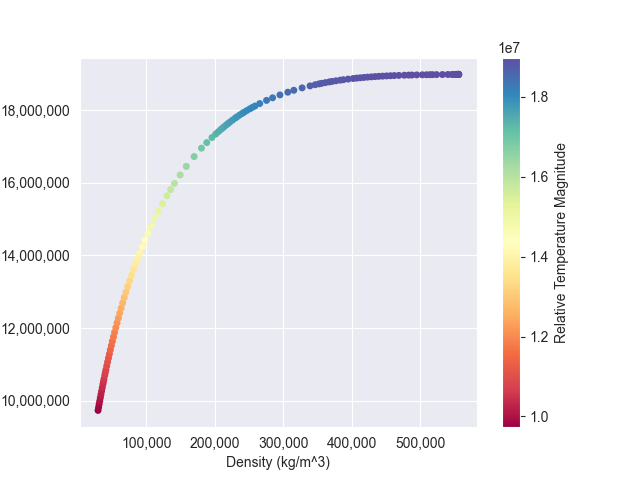

In [21]:
%matplotlib widget
plt.close('all')

## 2D plot this time
fig, ax = plt.subplots()

profile = profiles[_id].temperature_density_profile_2d()

scatter = ax.scatter(profile[0], profile[1], s=16, c=temps, cmap='Spectral', norm=norm)
plt.colorbar(scatter, label='Relative Temperature Magnitude')
ax.set_xlabel('Density (kg/m^3)')
ax.set_ylabel('Temperature (K)')

ax.xaxis.set_major_formatter(FuncFormatter(comma_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

plt.show()

In [109]:
## Also, we want stars that still have some hydrogen left
df_filtered = _df[_df['core_temperature'] > 1.1e7]
df_filtered

batch_idx  iteration_idx          mass   core_radius  \
source_id                                                                   
3895763112473649152          0            110  1.765144e+30  1.277347e+08   
3662578102339135872          0            120  1.826111e+30  1.326846e+08   
4015792467550694528          0            125  1.678619e+30  1.224585e+08   
4565282543223623040          0            145  1.713221e+30  1.247811e+08   
2815730020378243968          0            156  1.740888e+30  1.262782e+08   
...                        ...            ...           ...           ...   
1588058939312132992          3             70  1.745118e+30  1.275254e+08   
1588283170964613248          3             74  1.799980e+30  1.296868e+08   
1605775164012441344          3             75  2.158420e+30  1.518152e+08   
1352382401469775744          3             87  1.673692e+30  1.230972e+08   
1392090267474126848          3             98  2.388658e+30  1.649205e+08   

                     core_radius_error  original_core_radius        radius  \
source_id                                                                    
3895763112473649152           0.015933          1.257313e+08  7.205226e+08   
3662578102339135872           0.012678          1.310235e+08  6.846479e+08   
4015792467550694528           0.009647          1.212884e+08  6.013956e+08   
4565282543223623040           0.015547          1.228709e+08  6.348937e+08   
2815730020378243968          -0.001416          1.264572e+08  6.413945e+08   
...                                ...                   ...           ...   
1588058939312132992           0.015971          1.255207e+08  6.172602e+08   
1588283170964613248          -0.001224          1.298457e+08  7.167698e+08   
1605775164012441344           0.015077          1.495602e+08  9.208698e+08   
1352382401469775744           0.009467          1.219428e+08  6.404413e+08   
1392090267474126848           0.016488          1.622454e+08  1.127347e+09   

                     radius_error  original_radius           age  ...  \
source_id                                                         ...   
3895763112473649152      0.015933     7.092223e+08  1.264748e+10  ...   
3662578102339135872      0.012678     6.760765e+08  8.774010e+09  ...   
4015792467550694528      0.009647     5.956492e+08  1.013841e+10  ...   
4565282543223623040      0.015547     6.251741e+08  1.111209e+10  ...   
2815730020378243968     -0.001416     6.423040e+08  1.064244e+10  ...   
...                           ...              ...           ...  ...   
1588058939312132992      0.015971     6.075566e+08  7.712597e+09  ...   
1588283170964613248     -0.001224     7.176480e+08  1.176892e+10  ...   
1605775164012441344      0.015077     9.071918e+08  6.169912e+09  ...   
1352382401469775744      0.009467     6.344354e+08  1.220903e+10  ...   
1392090267474126848      0.016488     1.109061e+09  4.489689e+09  ...   

                     original_reaction_rates_per_unit_volume  \
source_id                                                      
3895763112473649152                             4.873259e+12   
3662578102339135872                             5.180590e+12   
4015792467550694528                             4.825255e+12   
4565282543223623040                             5.018455e+12   
2815730020378243968                             4.708930e+12   
...                                                      ...   
1588058939312132992                             5.131515e+12   
1588283170964613248                             4.555093e+12   
1605775164012441344                             4.602344e+12   
1352382401469775744                             5.149308e+12   
1392090267474126848                             4.928707e+12   

                                                         burning_zones  \
source_id                                                                
3895763112473649152  [{'zone_number': 699, 'thickness': 1567201.386...   

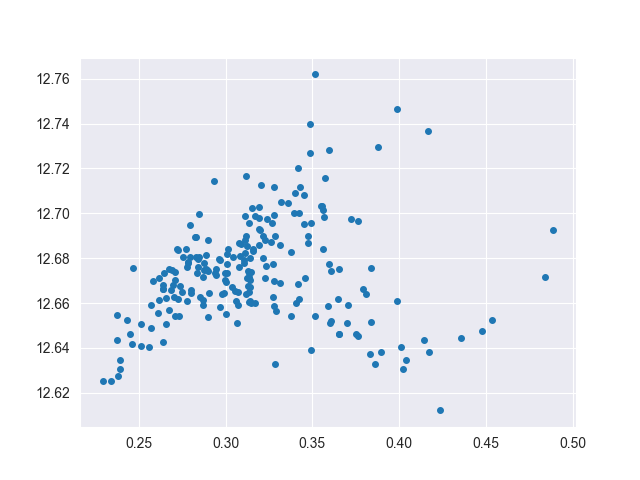

In [63]:
fig, ax = plt.subplots()
ax.scatter(df_filtered['core_mass'] / SOLAR_MASS, np.log10(df_filtered['reaction_rates_per_unit_volume']), s=16)

plt.show()

In [99]:
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly"
# Data for 3D scatter plot
x = df_filtered['core_density']
y = df_filtered['core_temperature']
z = np.log10(df_filtered['reaction_rates_per_unit_volume'])

mass = df_filtered['mass']

# Create the 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=5,
                color=z,
                colorscale='Plasma',
                opacity=0.8,
            ),
        )
    ]
)

fig.update_layout(
    title='Reaction Rates vs. Core Density and Temperature',
    scene=dict(
        xaxis_title='Core Density (kg/m^3)',
        yaxis_title='Temperature (K)',
        zaxis_title='Log Reaction Rate (log(reactions/s/m^3))',
    ),
    width=1200,
    height=1000,
)

# Show the plot inline in Jupyter
fig.show()

In [115]:
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FuncFormatter

### Render as a topology
x = df_filtered['core_density']
y = df_filtered['core_temperature']
z = np.log10(df_filtered['reaction_rates_per_unit_volume'])

grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')

# Create the 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=5,
                color=z,
                colorscale='Plasma',
                opacity=0.5,
            ),
        )
    ]
)

fig.add_trace(go.Surface(z=grid_z, x=grid_x, y=grid_y, colorscale='Plasma', opacity=0.8, colorbar=dict(title='Reaction Rates', len=0.8, thickness=20)))

fig.update_layout(
    title='Reaction Rates vs. Core Density and Temperature',
    scene=dict(
        xaxis_title='Core Density (kg/m^3)',
        yaxis_title='Temperature (K)',
        zaxis_title='Log Reaction Rate (log(reactions/s/m^3))',
    ),
    width=1200,
    height=1000,
)

max_idx = np.argmax(z)
print(f'Maximum reaction rate: {z[max_idx]:.5f} reactions/s/m^3 @ ({x[max_idx]:.5f}, {y[max_idx]:.5f})')

fig.show()

Maximum reaction rate: 12.76191 reactions/s/m^3 @ (84891.95721, 11990605.08598)


Loading profile 1440252621982696192
Density: 97541.97731286331 ± 41440.475754769555
Reaction Rates: 9344993923203.533 ± 7038634797209.237


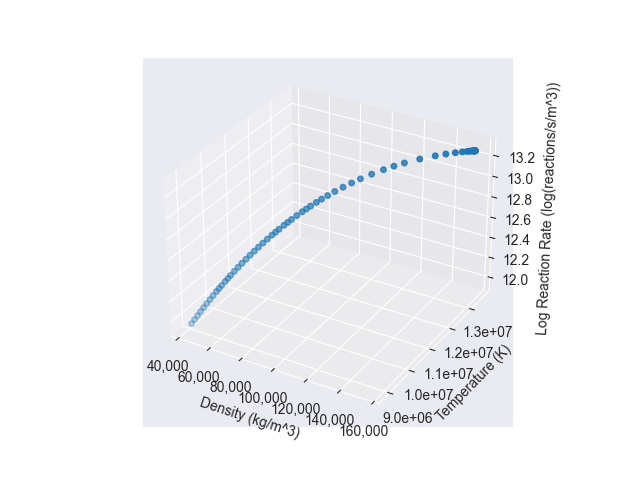

In [26]:
from matplotlib.ticker import FuncFormatter

random_profile = df.sample(1).index[0]
_id = random_profile
print(f'Loading profile {_id}')
profile = profiles[_id]
density = profile.burning_zones['density']
temperature = profile.burning_zones['temperature']
reaction_rates = profile.burning_zones['reaction_rates'] / profile.burning_zones['volume']
print(f'Density: {density.mean()} ± {density.std()}')
print(f'Reaction Rates: {reaction_rates.mean()} ± {reaction_rates.std()}')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def inline_scientific_formatter(value, _):
    if value == 0:
        return "0"
    return f"{value:.1e}"  # Format as 1.0e+7, 1.0e+6, etc.

def comma_formatter(x, pos):
    return f'{x:,.0f}'

formatter = FuncFormatter(inline_scientific_formatter)

ax.scatter(density, temperature, np.log10(reaction_rates), s=16)

ax.set_xlabel('Density (kg/m^3)')
ax.set_ylabel('Temperature (K)')
ax.set_zlabel('Log Reaction Rate (log(reactions/s/m^3))')

ax.xaxis.set_major_formatter(FuncFormatter(comma_formatter))
ax.yaxis.set_major_formatter(formatter)

plt.show()

## Run regressions

ChatGPT is suggesting using a Gaussian Process Regression model to predict the reaction rates.

In [27]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

X = np.vstack((df_filtered['core_density'], df_filtered['core_temperature'])).T

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

gpr.fit(X_scaled, np.log10(df_filtered['reaction_rates_per_unit_volume']))

gpr

C:\Users\maxiw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

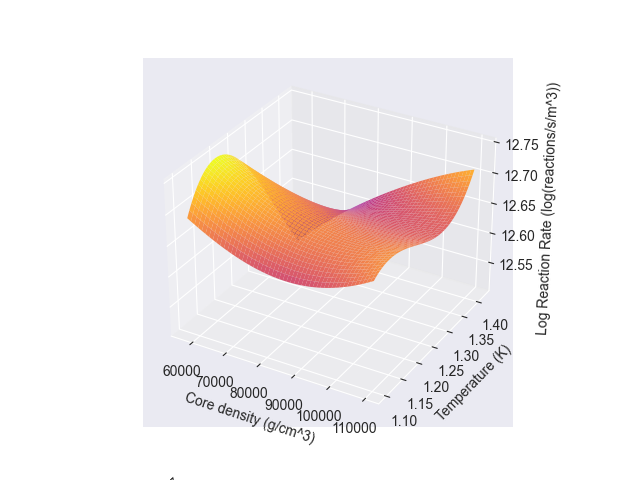

In [28]:
# Use the model to make another surface plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T
grid_points_scaled = scaler.transform(grid_points)
grid_z = gpr.predict(grid_points_scaled).reshape(grid_x.shape)

ax.plot_surface(grid_x, grid_y, grid_z, cmap='plasma', linewidth=0, antialiased=True, edgecolor='none')

ax.set_xlabel('Core density (g/cm^3)')
ax.set_ylabel('Temperature (K)')
ax.set_zlabel('Log Reaction Rate (log(reactions/s/m^3))')

plt.show()

In [116]:
### Let's try a multi-variate regression
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

df_filtered = df_filtered[df_filtered['core_temperature'] > 1.1e7]
X = df_filtered[['core_density', 'core_temperature']].copy()
y = np.log10(df_filtered['reaction_rates_per_unit_volume'])

poly = PolynomialFeatures(degree=3, include_bias=False)
temp_poly = poly.fit_transform(np.log10(X[['core_temperature']]))
X = pd.concat([(X['core_density']), pd.DataFrame(temp_poly, index=X.index, columns=['log(core_temperature)', 'log(core_temperature)^2', 'log(core_temperature)^3'])], axis=1)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()
# X

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     reaction_rates_per_unit_volume   R-squared:                       0.526
Model:                                        OLS   Adj. R-squared:                  0.518
Method:                             Least Squares   F-statistic:                     60.01
Date:                            Tue, 07 Jan 2025   Prob (F-statistic):           5.15e-34
Time:                                    21:48:15   Log-Likelihood:                 601.21
No. Observations:                             221   AIC:                            -1192.
Df Residuals:                                 216   BIC:                            -1175.
Df Model:                                       4                                         
Covariance Type:                        nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1.911e+05   1.87e+04    -10.206      0.000   -2.28e+05   -1.54e+05
core_density            -1.032e-06   1.17e-07     -8.824      0.000   -1.26e-06   -8.02e-07
log(core_temperature)    8.079e+04   7924.855     10.195      0.000    6.52e+04    9.64e+04
log(core_temperature)^2 -1.138e+04   1117.813    -10.183      0.000   -1.36e+04   -9179.503
log(core_temperature)^3   534.5520     52.556     10.171      0.000     430.964     638.140
==============================================================================
Omnibus:                       41.725   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.441
Skew:                           0.898   Prob(JB):                     3.79e-20
Kurtosis:                       5.548   Cond. No.                     1.60e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.26e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [117]:
X['interaction'] = X['core_density'] * X['log(core_temperature)']

model_interaction = sm.OLS(y, X).fit()
model_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     reaction_rates_per_unit_volume   R-squared:                       0.609
Model:                                        OLS   Adj. R-squared:                  0.600
Method:                             Least Squares   F-statistic:                     67.03
Date:                            Tue, 07 Jan 2025   Prob (F-statistic):           5.59e-42
Time:                                    21:48:17   Log-Likelihood:                 622.45
No. Observations:                             221   AIC:                            -1233.
Df Residuals:                                 215   BIC:                            -1213.
Df Model:                                       5                                         
Covariance Type:                        nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1.874e+05   1.71e+04    -10.985      0.000   -2.21e+05   -1.54e+05
core_density               -0.0002   3.24e-05     -6.783      0.000      -0.000      -0.000
log(core_temperature)    7.918e+04   7219.141     10.968      0.000     6.5e+04    9.34e+04
log(core_temperature)^2 -1.115e+04   1018.297    -10.950      0.000   -1.32e+04   -9142.886
log(core_temperature)^3   523.3471     47.878     10.931      0.000     428.976     617.718
interaction              3.087e-05   4.57e-06      6.751      0.000    2.19e-05    3.99e-05
==============================================================================
Omnibus:                       62.628   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.634
Skew:                           1.213   Prob(JB):                     4.41e-39
Kurtosis:                       6.646   Cond. No.                     1.15e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.26e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

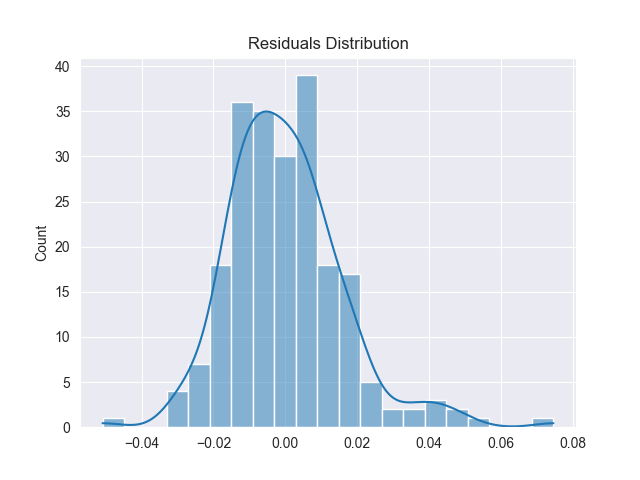

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
residuals = model.resid
sns.histplot(residuals, kde=True, ax=ax)
plt.title('Residuals Distribution')
plt.show()

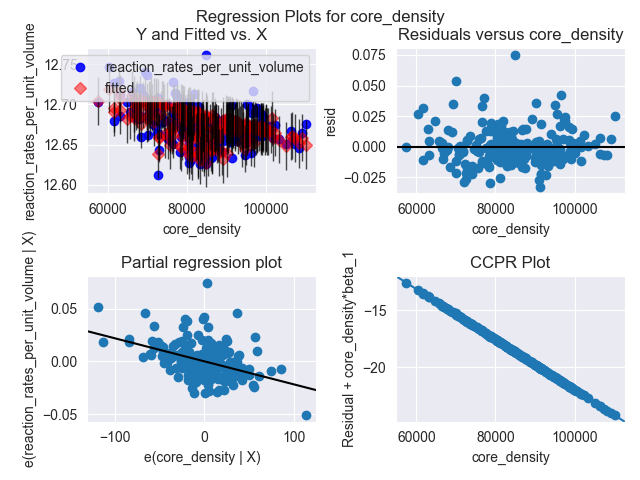

In [119]:
%matplotlib widget

fig = plt.figure()

sm.graphics.plot_regress_exog(model_interaction, 'core_density', fig)
plt.show()

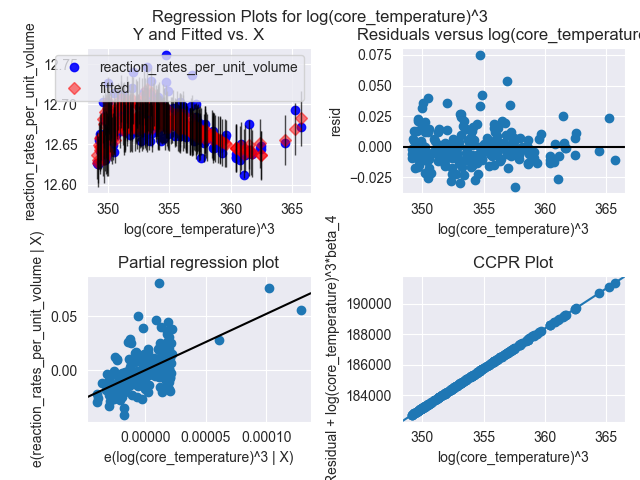

In [33]:
%matplotlib widget

fig = plt.figure()

sm.graphics.plot_regress_exog(model_interaction, 'log(core_temperature)^3', fig)
plt.show()

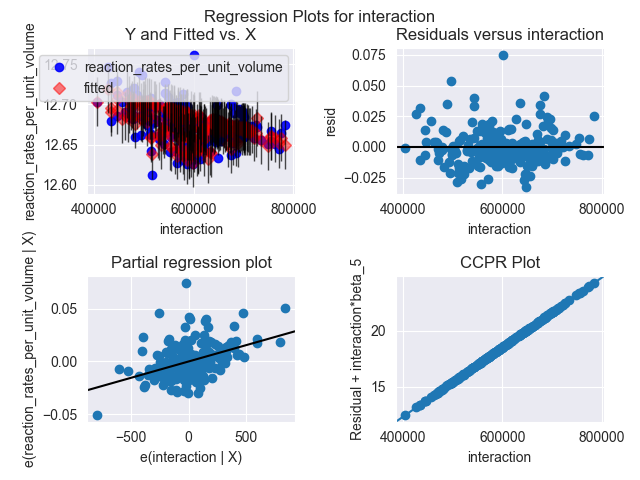

In [120]:
%matplotlib widget

fig = plt.figure()

sm.graphics.plot_regress_exog(model_interaction, 'interaction', fig)
plt.show()

In [132]:
# Plot density data vs reaction rates
_df = df_filtered.copy()
_df = _df[_df['core_temperature'] > 1.1e7]

x = _df['core_temperature']
y = np.log10(_df['reaction_rates_per_unit_volume'])

model = np.poly1d(np.polyfit(x, y, 3))

_inputs = np.linspace(x.min(), x.max(), 250)

fig = go.Figure(
    data=[
        go.Scatter(x=x, y=y, mode='markers', marker=dict(size=5, color='blue'), name='Data'),
        go.Scatter(x=_inputs, y=model(_inputs), mode='lines', marker=dict(color='red'), name='Fit'),
    ]
)

fig.update_layout(
    title='Reaction Rates vs. Core Density and Temperature',
    scene=dict(
        xaxis_title='Core Temperature (K)',
        yaxis_title='Log Reaction Rate (log(reactions/s/m^3))',
    ),
    width=1200,
    height=1000,
)
fig.show()

In [133]:
# Plot density data vs reaction rates
_df = df_filtered.copy()
_df = _df[_df['core_temperature'] > 1.1e7]


x = _df['core_density']
y = np.log10(_df['reaction_rates_per_unit_volume'])

model = np.poly1d(np.polyfit(x, y, 1))

_inputs = np.linspace(x.min(), x.max(), 250)

fig = go.Figure(
    data=[
        go.Scatter(x=x, y=y, mode='markers', marker=dict(size=5, color='blue'), name='Data'),
        go.Scatter(x=_inputs, y=model(_inputs), mode='lines', marker=dict(color='red'), name='Fit'),
    ]
)

fig.update_layout(
    title='Reaction Rates vs. Core Density and Temperature',
    scene=dict(
        xaxis_title='Core Density (kg/m^3)',
        yaxis_title='Log Reaction Rate (log(reactions/s/m^3))',
    ),
    width=1200,
    height=1000,
)

fig.show()

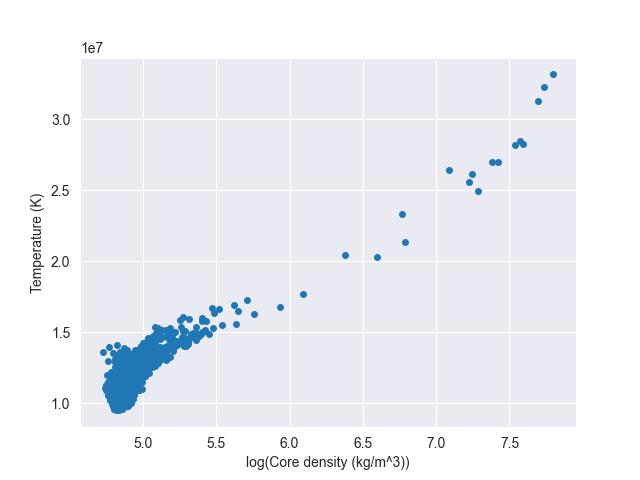

In [37]:
fig, ax = plt.subplots()

ax.scatter(np.log10(df['core_density']), df['core_temperature'], s=16)

ax.set_xlabel('log(Core density (kg/m^3))')
ax.set_ylabel('Temperature (K)')

plt.show()

In [38]:
plt.close('all')

In [138]:
## Use the model to make another surface plot

x = df_filtered['core_density']
y = df_filtered['core_temperature']

grid_x, grid_y = np.meshgrid(
    np.linspace(x.min() * 1, x.max() * 1, 50),
    np.linspace(y.min() * 1, y.max() * 1, 50)
)

_x = grid_x.ravel()
_y = grid_y.ravel()

input_data = pd.DataFrame(
    {
        'core_density': _x,
        'log(core_temperature)': np.log10(_y),
        'log(core_temperature)^2': np.log10(_y) ** 2,
        'log(core_temperature)^3': np.log10(_y) ** 3,
        'interaction': _x * np.log10(_y),
    }
)

input_data = sm.add_constant(input_data)

grid_z = model_interaction.predict(input_data).values.reshape(grid_x.shape)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=5,
                color=z,
                colorscale='Plasma',
                opacity=0.5,
            ),
        ),
        go.Surface(z=grid_z, x=grid_x, y=grid_y, colorscale='Plasma', opacity=0.8, colorbar=dict(title='Reaction Rates', len=0.8, thickness=20)),
    ]
)

fig.update_layout(
    title='Reaction Rates vs. Core Density and Temperature',
    scene=dict(
        xaxis_title='Core Density (kg/m^3)',
        yaxis_title='Temperature (K)',
        zaxis_title='Log Reaction Rate (log(reactions/s/m^3))',
    ),
    width=1200,
    height=1000,
)

fig.show()

In [155]:
_x = df_filtered['core_density']
_y = df_filtered['core_temperature']
_z = model_interaction.resid

x_space = np.linspace(_x.min(), _x.max(), 100)
y_space = np.linspace(_y.min(), _y.max(), 100)

x_grid, y_grid = np.meshgrid(x_space, y_space)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=_x,
            y=_y,
            z=_z,
            mode='markers',
            marker=dict(
                size=5,
                color=_z,
                colorscale='balance',
                opacity=0.8,
            ),
        ),
        go.Surface(x=x_grid, y=y_grid, z=np.zeros_like(x_grid), opacity=0.5, showscale=False, colorscale="Reds"),
    ]
)

fig.update_layout(
    title='Residuals vs. Core Density and Temperature',
    scene=dict(
        xaxis_title='Core Density (kg/m^3)',
        yaxis_title='Temperature (K)',
        zaxis_title='Residuals',
    ),
    width=1200,
    height=1000,
)

fig.show()

# Final equation:

$$
\begin{align*}
\log{\hat{y}} = &-0.000220(\rho) \\
&+ 79180.450698\log{T}  \\
&- 11150.009980\log({T})^2  \\
&+ 523.347072\log({T})^3 \\
&+ 0.000031(\rho \cdot \log{T})
\end{align*}
$$

